# P3 - Notebook 1/2 :: Dataset exploration

## Table of content

1. **[Loading the cleaned data](#loading)**
2. **[Correlation matric and pairploting](#correlation_and_pairploting)**
    1. [Correlation matrix](#correlation_matrix)
    2. [Pairploting](#pairploting)
3. **[Univariate and bivariate analysis](#analysis)**
    1. [Nutrition score](#analysis_nutriscore)
    2. [Energy (kcal)](#analysis_energy)
    3. [Sugars and carbohydrates](#analysis_carbohydrates)
    4. [Fat and saturated fat](#analysis_fats)
    5. [Proteins](#analysis_proteins)
    6. [Salt](#analysis_salt)
    7. [Fibers](#analysis_fibers)
    8. [Nutrigrade and nutrients](#nutrigrade_nutrients)
4. **[Organic label influence on nutrition score (ANOVA)](#organic_nutriscore)**
    1. [Nutrition score distributions comparison](#organic_nutriscore_distributions)
    2. [Checking ANOVA hypothesis](#anova_hypothesis)
    3. [Performing Kruskal-Wallis ANOVA](#kruskal_wallis)
    4. [Conclusion](#anova_conclusion)
5. **[Exploring our variables with a PCA](#pca)**
6. **[Training nutrigrade KNN](#nutrigrade_knn)**
    1. [Finding optimal K value](#knn_testing_k)
    2. [Training KNN](#knn_training)
7. **[Imputing missing values](#imputing_missing)**
    1. [Imputing other nutritional values using category mean](#imputing_nutritional)
    2. [Imputing missing nutrigrades using KNN](#imputing_nutrigrade)
8. **[Prototyping the application](#prototype)**



In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
import matplotlib.image as mpimg
import seaborn as sns
import scipy as sp

import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import plotly.io as pio
pio.renderers.default='iframe'
from skimage import io

import re
import math

from sklearn import decomposition
from sklearn import preprocessing
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score

from common_functions import *

sns.set()
pd.set_option('display.max_columns', None)

## 1. Loading the cleaned data<a name="loading"></a>
**/!\ WARNING : THIS NOTEBOOK USE THE OUTPUT FILE OF THE FIRST NOTEBOOK**

In [2]:
data = pd.read_csv('data/off_cleaned_data.csv', sep='\t', index_col=0)

# We add the nutriscore letter to display the color on the plots
data.loc[data['nutrition-score-fr_100g'].notnull(), 'nutriscore_grade'] = data['nutrition-score-fr_100g'].apply(get_nutriscore_letter)

In [3]:
data

url  \
0       http://world-en.openfoodfacts.org/product/0000...   
1       http://world-en.openfoodfacts.org/product/0000...   
2       http://world-en.openfoodfacts.org/product/0000...   
3       http://world-en.openfoodfacts.org/product/0000...   
4       http://world-en.openfoodfacts.org/product/0000...   
...                                                   ...   
289195  http://world-en.openfoodfacts.org/product/9999...   
289196  http://world-en.openfoodfacts.org/product/9999...   
289197  http://world-en.openfoodfacts.org/product/9999...   
289198  http://world-en.openfoodfacts.org/product/9999...   
289199  http://world-en.openfoodfacts.org/product/9999...   

                          product_name  \
0          moutarde au moût de raisin    
1            Salade de carottes râpées   
2                   Tarte noix de coco   
3                     Compote de poire   
4       Salade de macedoine de légumes   
...                                ...   
289195                     Riz au lait   
289196         Mousse au chocolat noir   
289197                     Riz parfumé   
289198                  Minis beignets   
289199           Steak haché pur boeuf   

                                          image_small_url  \
0       https://static.openfoodfacts.org/images/produc...   
1       https://static.openfoodfacts.org/images/produc...   
2       https://static.openfoodfacts.org/images/produc...   
3       https://static.openfoodfacts.org/images/produc...   
4       https://static.openfoodfacts.org/images/produc...   
...                                                   ...   
289195  https://static.openfoodfacts.org/images/produc...   
289196  https://static.openfoodfacts.org/images/produc...   
289197  https://static.openfoodfacts.org/images/produc...   
289198  https://static.openfoodfacts.org/images/produc...   
289199  https://static.openfoodfacts.org/images/produc...   

                       main_category  \
0                        en:mustards   
1       en:seasoned-shredded-carrots   
2                    en:coconut-pies   
3                   en:pear-compotes   
4           en:vegetables-macedoines   
...                              ...   
289195              en:rice-puddings   
289196          en:chocolate-mousses   
289197             en:aromatic-rices   
289198             en:sweet-fritters   
289199         en:ground-beef-steaks   

                                          categories_tags organic  \
0        en:groceries,en:condiments,en:sauces,en:mustards   False   
1       en:meals,en:prepared-vegetables,en:grated-carr...     NaN   
2                   en:pies,en:sweet-pies,en:coconut-pies     NaN   
3       en:plant-based-foods-and-beverages,en:plant-ba...     NaN   
4       en:meals,en:prepared-vegetables,en:starters,en...     NaN   
...                                                   ...     ...   
289195           en:desserts,en:puddings,en:rice-puddings     NaN   
289196  en:desserts,en:chocolate-desserts,en:chocolate...     NaN   
289197  en:plant-based-foods-and-beverages,en:plant-ba...     NaN   
289198        en:snacks,en:sweet-snacks,en:sweet-fritters     NaN   
289199  en:meats,en:beef,en:steaks,en:beef-steaks,en:g...     NaN   

        nutrition-score-fr_100g  saturated-fat_100g  sugars_100g  \
0                          18.0                 2.2         22.0   
1                           1.0                 0.1          3.9   
2                          14.0                15.5         21.9   
3                          -2.0                 0.0         27.0   
4                           1.0                 1.0          1.0   
...                         ...                 ...          ...   
289195                      7.0                 4.3         14.0   
289196                     17.0                17.0         18.0   
289197                      0.0                 0.0          0.0   
289198                     15.0                 6.0         10.4   
289199                   

## 2. Correlation matrix and pairploting<a name="correlation_and_pairploting"></a>
### 2.1 Correlation matrix<a name="correlation_matrix"></a>
We plot the correlation matrix before any analysis in order to know if some linear correlation can be searched later.

<AxesSubplot:>

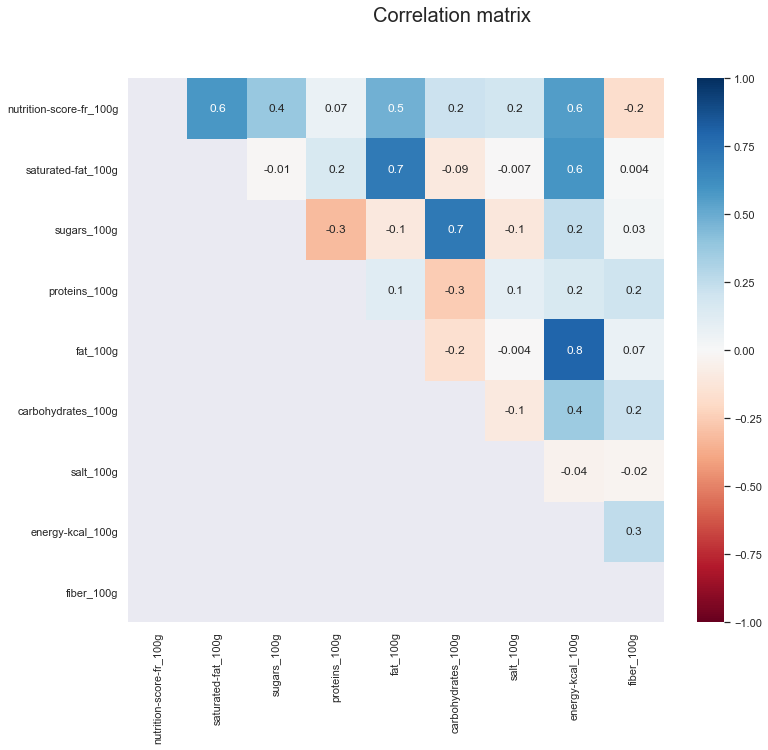

In [4]:
correlation_matrix = data.corr(method='pearson')
triangular_matrix = np.tril(correlation_matrix)

fig, ax = plt.subplots(figsize=(12,10)) 
fig.suptitle("Correlation matrix", fontsize=20)
sns.heatmap(correlation_matrix, annot=True, fmt='.1g', mask=triangular_matrix, vmin=-1, vmax=1, cmap= 'RdBu')

We notive some Pearson value greater that 0.5

We keep them in mind for later.

### 2.2 Pairploting<a name="pairploting"></a>
We pairplot all our numeric variables even if the pairplot won't be useful because of the high number of points.

Moreover, for some correlations, the correlation matrix above is better.

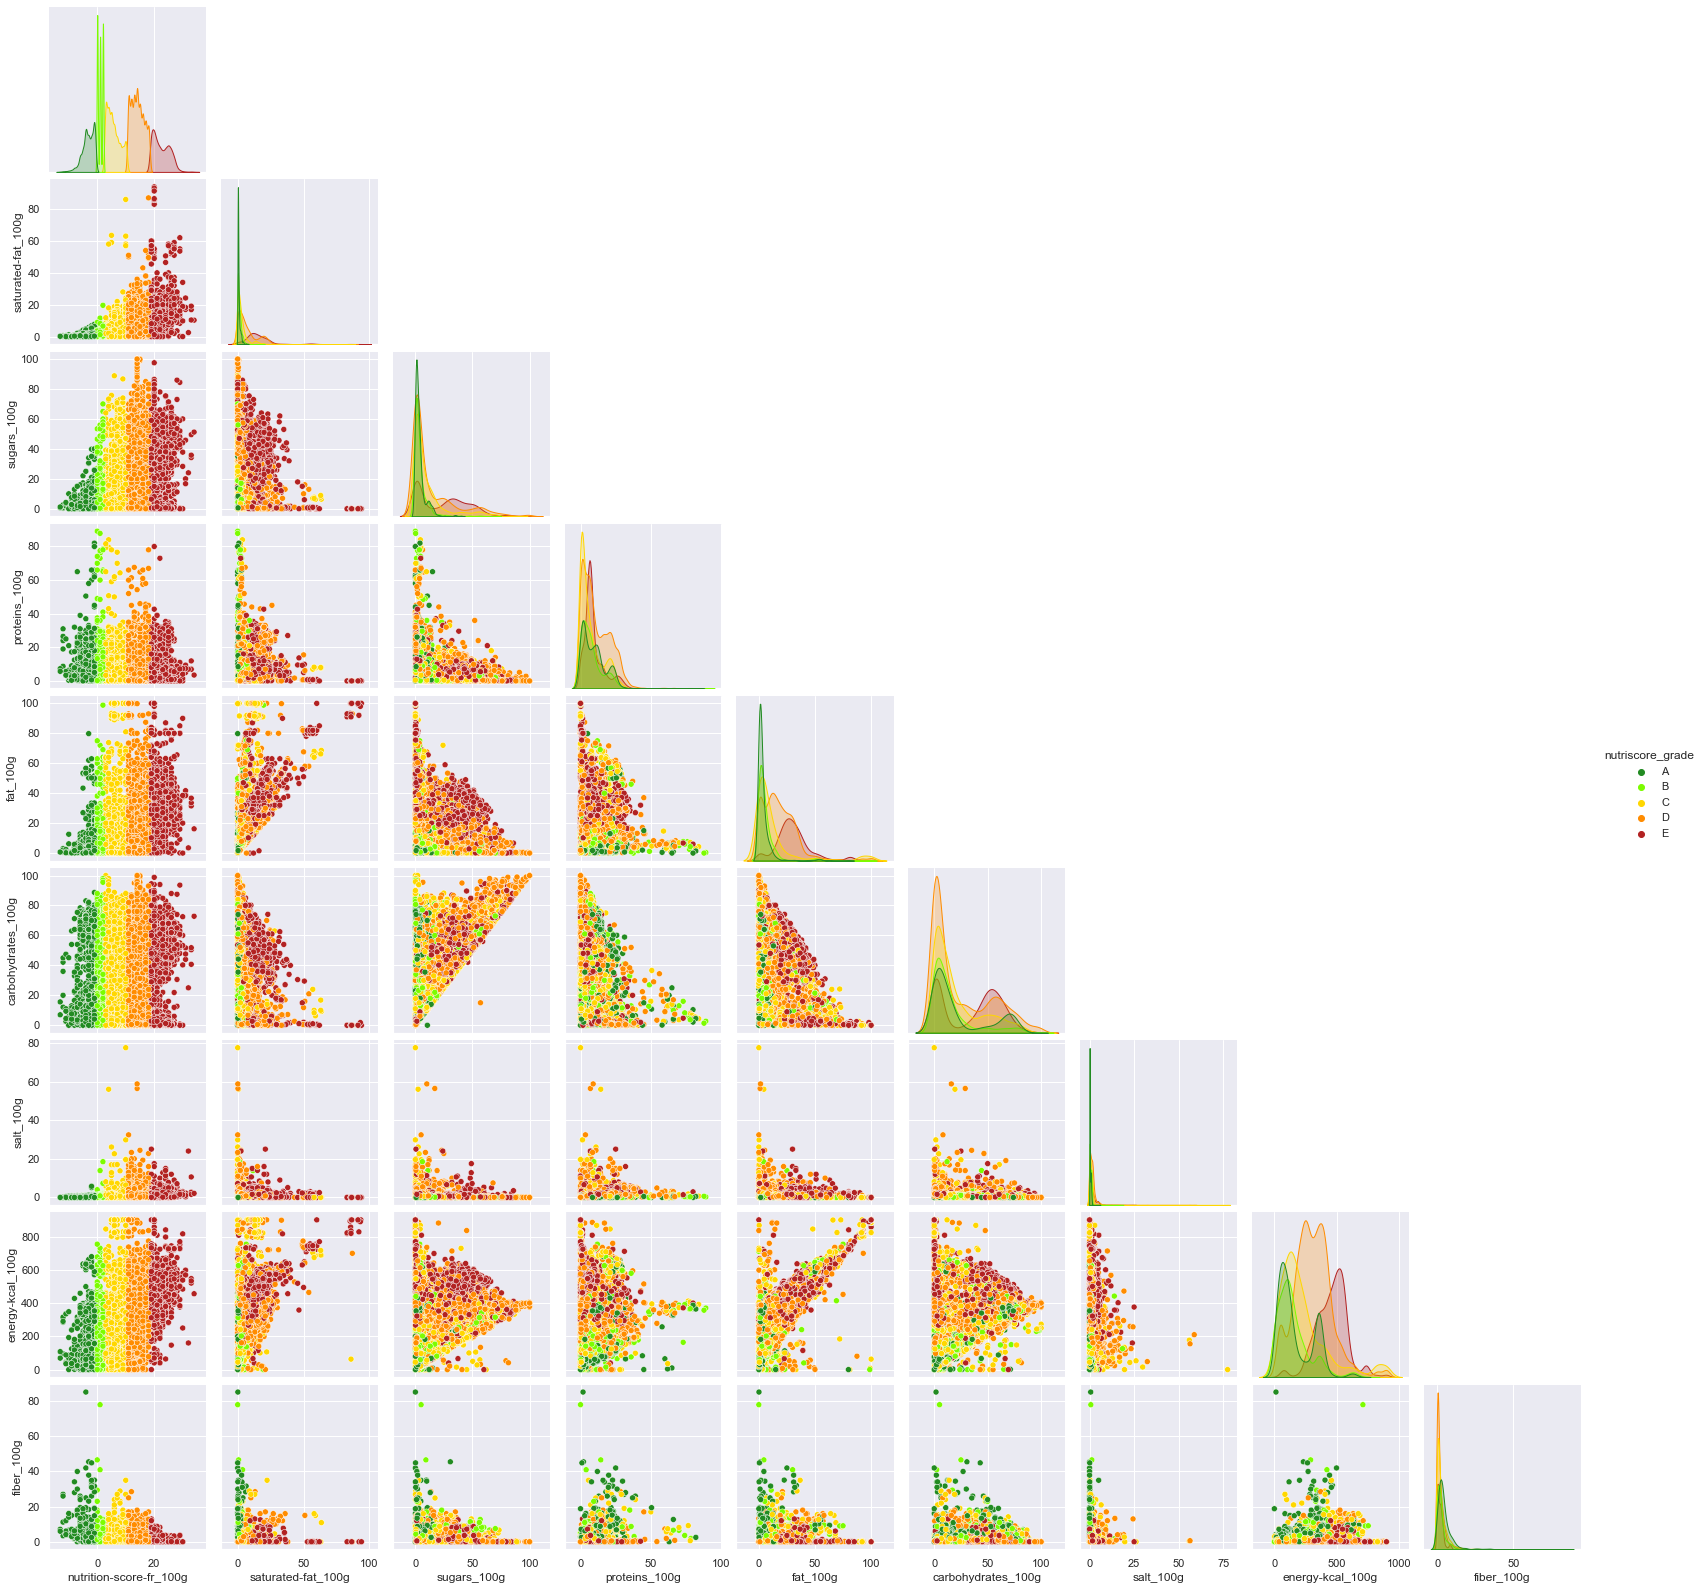

In [5]:
# We plot the pairplot only on a 5% sample of the dataset to make it quicker
nutritional_columns = [x for x in data.columns.values if x.endswith('_100g')] + ['nutriscore_grade']
nutritional_data = data[nutritional_columns].sample(round(len(data)*0.05))
sns.pairplot(nutritional_data, corner=True, hue='nutriscore_grade', hue_order=['A', 'B', 'C', 'D', 'E'], palette=NUTRIGRADE_COLORS)

## 3. Univariate and bivariate analysis<a name="analysis"></a>

### 3.1 Nutrition score<a name="analysis_nutriscore"></a>

A    37202
B    35132
C    61798
D    86706
E    46670
Name: nutriscore_grade, dtype: int64

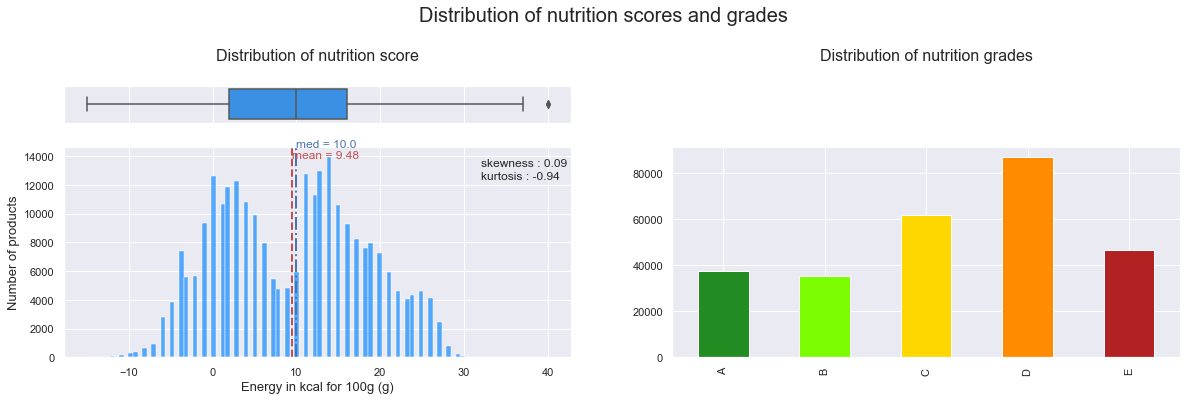

In [6]:
fig, axes = plt.subplots(figsize=(20,5), ncols=2, nrows=2, sharex="col", gridspec_kw={"height_ratios": (.15, .85)})
fig.suptitle('Distribution of nutrition scores and grades', fontsize=20, y=1.1)

# Comparing the distribution using the nutriscore 
plot_data_hist(data['nutrition-score-fr_100g'], 
               ax=axes[1][0], 
               box_ax=axes[0][0],
               color="dodgerblue", 
               title="Distribution of nutrition score", 
               xlabel="Energy in kcal for 100g (g)", 
               ylabel="Number of products")
               
nutriscore_grade_data = data['nutriscore_grade'].value_counts().sort_index()
axes[0][1].set_title("Distribution of nutrition grades", fontsize=16, pad=25)
nutriscore_grade_data.plot(ax=axes[1][1], kind="bar", color=NUTRIGRADE_COLORS.values())

axes[0][1].axis('off')

nutriscore_grade_data

#### Evolution of nutriscore according to other nutritional columns

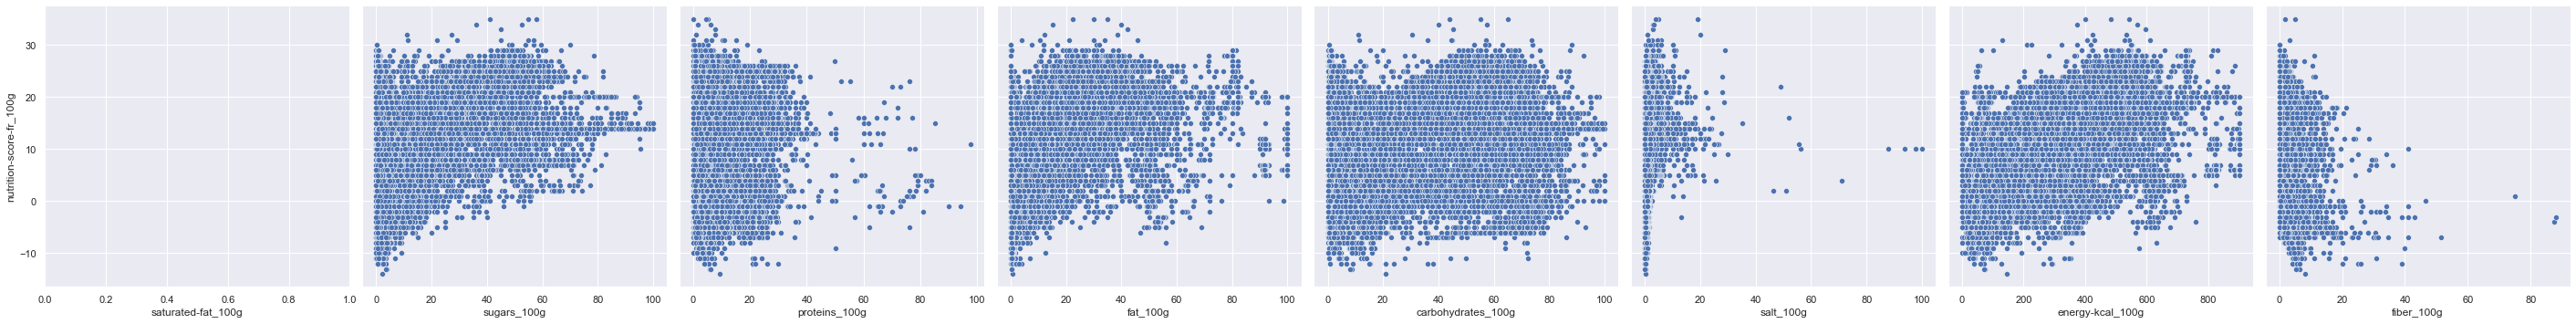

In [7]:
# Working on a sample dataset to make it quicker
SAMPLE_PERCENTAGE = 10
data_sample = data.sample(round(len(data)*SAMPLE_PERCENTAGE/100))

sns.pairplot(data_sample, 
             x_vars=get_nutritional_columns(data_sample, exclude_starts=['nutrition']),
             y_vars=["nutrition-score-fr_100g"],
             height=5)

### 3.2 Energy (kcal)<a name="analysis_energy"></a>

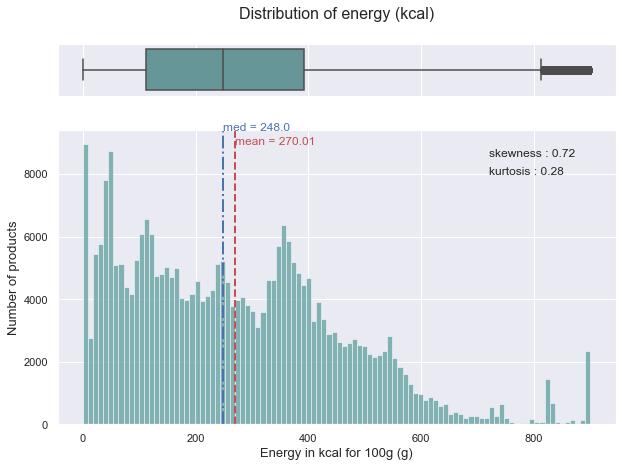

In [8]:
fig, axes = plt.subplots(figsize=(10,7), nrows=2, sharex="col", gridspec_kw={"height_ratios": (.15, .85)})

plot_data_hist(data['energy-kcal_100g'], 
               ax=axes[1], 
               box_ax=axes[0],
               color="cadetblue", 
               title="Distribution of energy (kcal)", 
               xlabel="Energy in kcal for 100g (g)", 
               ylabel="Number of products")

### 3.3 Sugars and carbohydrates<a name="analysis_carbohydrates"></a>
#### Distributions

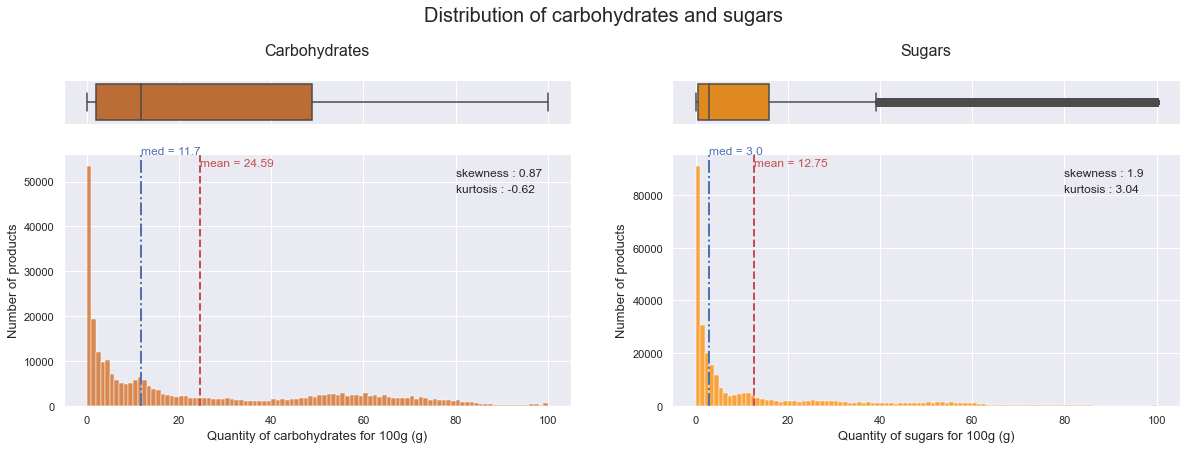

In [9]:
fig, axes = plt.subplots(figsize=(20,6), ncols=2, nrows=2, sharex="col", gridspec_kw={"height_ratios": (.15, .85)})
fig.suptitle("Distribution of carbohydrates and sugars", fontsize=20, y=1.05)

# Plotting carbohydrates distribution
plot_data_hist(data['carbohydrates_100g'], 
               ax=axes[1][0], 
               box_ax=axes[0][0],
               color="chocolate", 
               title="Carbohydrates", 
               xlabel="Quantity of carbohydrates for 100g (g)", 
               ylabel="Number of products")

# Plotting sugars distribution
plot_data_hist(data['sugars_100g'], 
               ax=axes[1][1],
               box_ax=axes[0][1],
               color="darkorange", 
               title="Sugars", 
               xlabel="Quantity of sugars for 100g (g)", 
               ylabel="Number of products")

#### Correlation / Linear regression
At first let's have a look at the scatter plot of these 2 columns that have a **0.7 Pearson coef** according to the correlation matrix.

Text(0.5, 1.0, 'Quantile regression between sugars and carbohydrates (r = 0.7)')

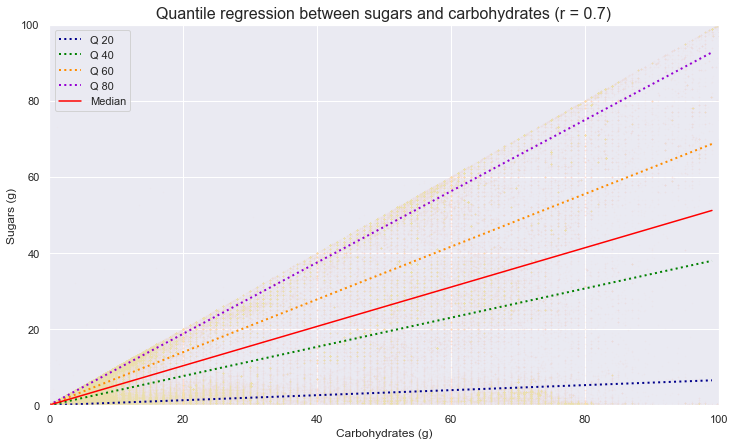

In [10]:
not_null_sugar_data = data[(data['carbohydrates_100g'].notnull()) & (data['sugars_100g'].notnull())].filter(items=['carbohydrates_100g', 'sugars_100g'], axis="columns")

fig, ax = plt.subplots(figsize=(12,7))

ax.scatter(not_null_sugar_data['carbohydrates_100g'], not_null_sugar_data['sugars_100g'], s=1, color="navajowhite", alpha=.02)
plot_quantile_regression(not_null_sugar_data, X_column='carbohydrates_100g', y_column='sugars_100g', ax=ax)

ax.set_ylim(ymin=0, ymax=100)
ax.set_xlim(xmin=0, xmax=100)
ax.set_xlabel("Carbohydrates (g)")
ax.set_ylabel("Sugars (g)")
ax.set_title("Quantile regression between sugars and carbohydrates (r = 0.7)", fontsize=16)

### 3.4 Fat and saturated fat<a name="analysis_fats"></a>

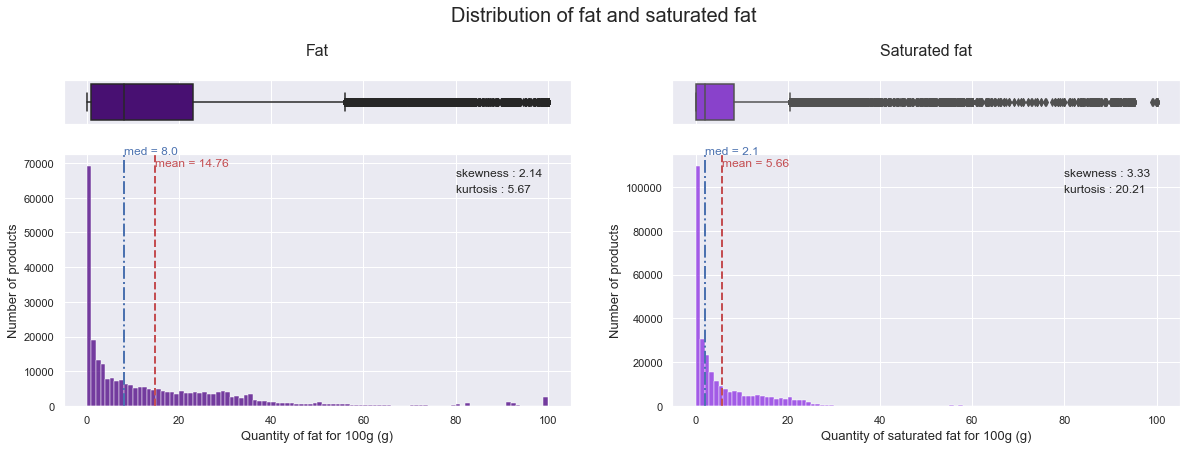

In [11]:
fig, axes = plt.subplots(figsize=(20,6), ncols=2, nrows=2, sharex="col", gridspec_kw={"height_ratios": (.15, .85)})
fig.suptitle("Distribution of fat and saturated fat", fontsize=20, y=1.05)

# Plotting fat distribution
plot_data_hist(data['fat_100g'], 
               ax=axes[1][0], 
               box_ax=axes[0][0], 
               color="indigo", 
               title="Fat", 
               xlabel="Quantity of fat for 100g (g)", 
               ylabel="Number of products")

# Plotting saturated fats distribution
plot_data_hist(data['saturated-fat_100g'], 
               ax=axes[1][1], 
               box_ax=axes[0][1],
               color="blueviolet", 
               title="Saturated fat", 
               xlabel="Quantity of saturated fat for 100g (g)", 
               ylabel="Number of products")

#### Correlation / Linear regression

Text(0.5, 1.0, 'Quantile regression between fat and saturated fat (pearson = 0.7)')

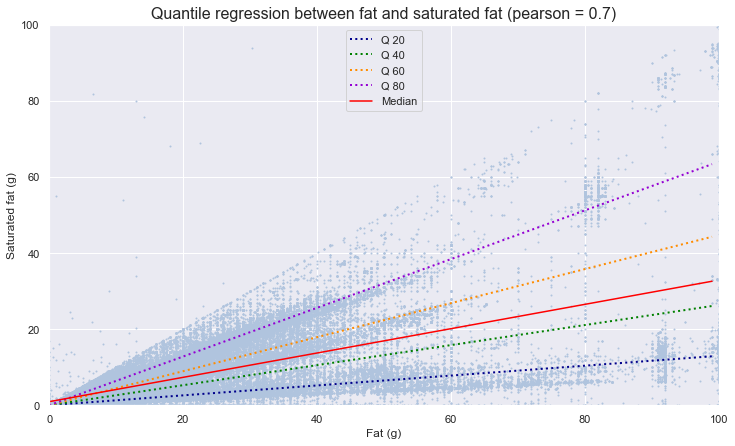

In [12]:
not_null_fat_data = data[(data['fat_100g'].notnull()) & (data['saturated-fat_100g'].notnull())].filter(items=['fat_100g', 'saturated-fat_100g'], axis="columns")

# Forced to rename saturated fat columns for linear regression library
not_null_fat_data = not_null_fat_data.rename(columns={'saturated-fat_100g': 'saturatedfat_100g'})

fig, ax = plt.subplots(figsize=(12,7))

ax.scatter(not_null_fat_data['fat_100g'], not_null_fat_data['saturatedfat_100g'], s=1, color="lightsteelblue")
plot_quantile_regression(not_null_fat_data, X_column='fat_100g', y_column='saturatedfat_100g', ax=ax)

ax.set_ylim(ymin=0, ymax=100)
ax.set_xlim(xmin=0, xmax=100)
ax.set_xlabel("Fat (g)")
ax.set_ylabel("Saturated fat (g)")
ax.set_title("Quantile regression between fat and saturated fat (pearson = 0.7)", fontsize=16)

### 3.5 Proteins<a name="analysis_proteins"></a>

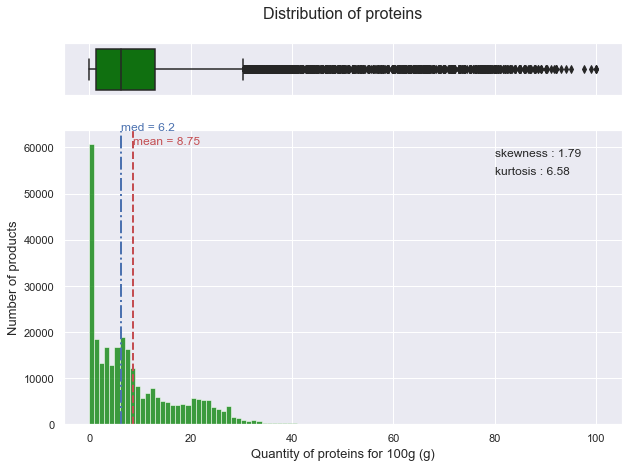

In [13]:
plot_data_hist(data['proteins_100g'], 
               color="green", 
               title="Distribution of proteins", 
               xlabel="Quantity of proteins for 100g (g)", 
               ylabel="Number of products")

### 3.6 Salt<a name="analysis_salt"></a>

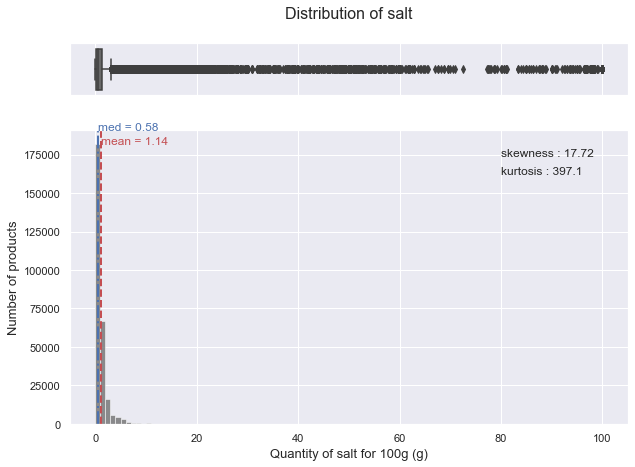

In [14]:
plot_data_hist(data['salt_100g'], 
               color="dimgrey", 
               title="Distribution of salt", 
               xlabel="Quantity of salt for 100g (g)", 
               ylabel="Number of products")

### 3.7 Fibers<a name="analysis_fibers"></a>

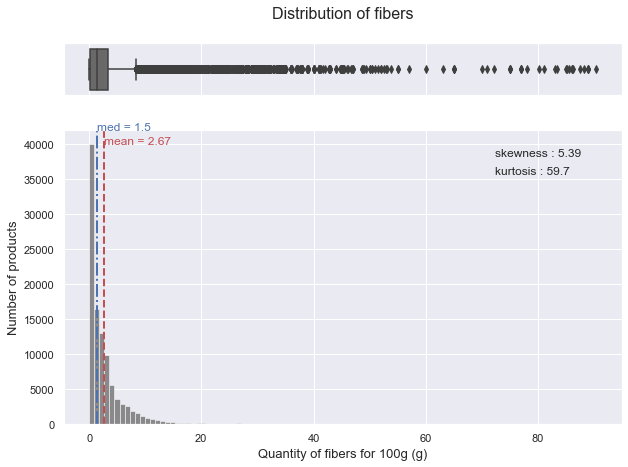

In [15]:
plot_data_hist(data['fiber_100g'], 
               color="dimgrey", 
               title="Distribution of fibers", 
               xlabel="Quantity of fibers for 100g (g)", 
               ylabel="Number of products")

### 3.8 Nutrigrade and nutrients<a name="nutrigrade_nutrients"></a>

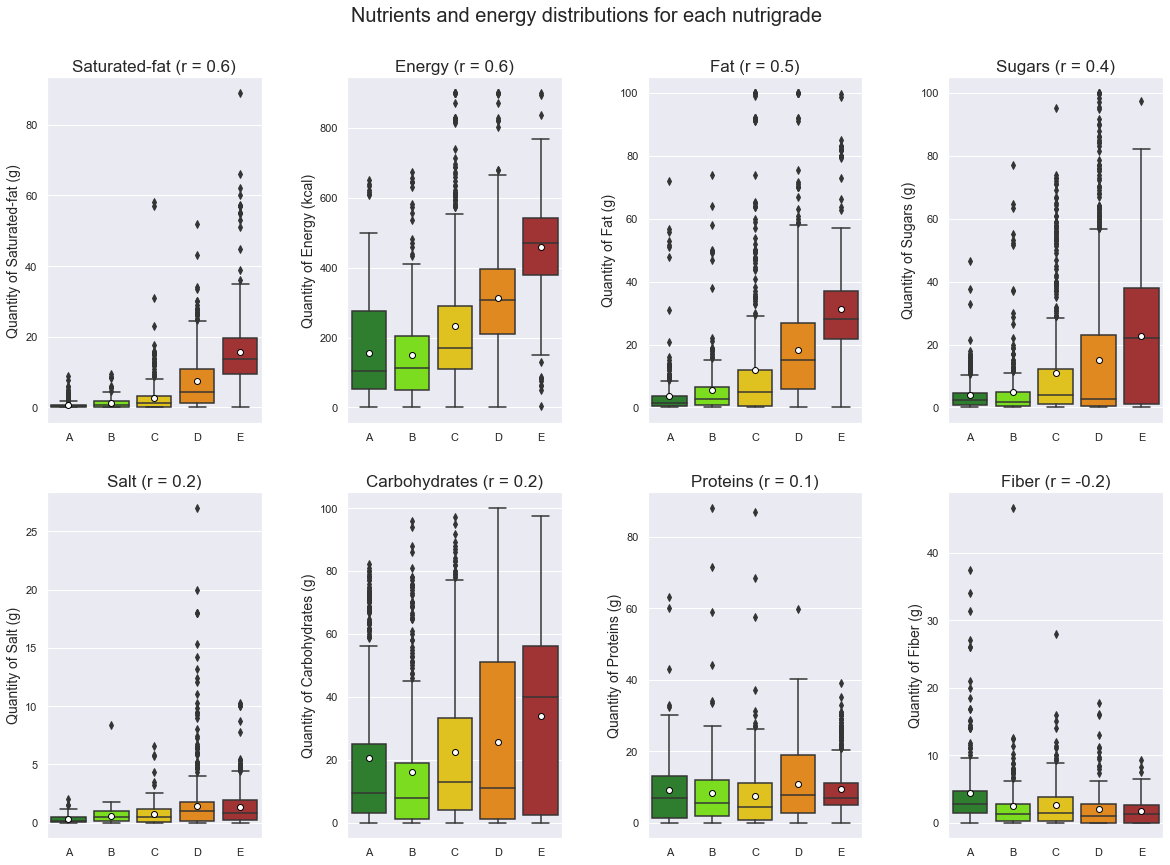

In [16]:
# Working on a data sample
nutritional_columns = get_nutritional_columns(data, exclude_starts=['nutrition'])+['nutriscore_grade']
data_sample = data[nutritional_columns].sample(round(len(data)*0.01))

# Sorting columns by Pearson desc
pearsons = []
for column in nutritional_columns:
    if column in correlation_matrix['nutrition-score-fr_100g']:
        pearson = round(correlation_matrix['nutrition-score-fr_100g'].loc[column],1)
    else:
        pearson = 0.0
    pearsons.append(pearson)
nutritional_columns = [x for _, x in sorted(zip(pearsons, nutritional_columns), reverse=True)]

# Calculating number of rows and cols to display it cleanly
MAX_COLS = 4
if len(nutritional_columns)-1 <= MAX_COLS:
    nrows = 1
    ncols = len(nutritional_columns)-1
else:
    nrows = math.ceil((len(nutritional_columns)-1) / MAX_COLS)
    ncols = MAX_COLS

# Preparing figure
fig, axes = plt.subplots(figsize=(20,nrows*7), nrows=nrows, ncols=ncols)
fig.subplots_adjust(hspace=0.2, wspace=0.4)
fig.suptitle("Nutrients and energy distributions for each nutrigrade", fontsize=20, y=0.95)

# Ploting each boxplot
nutritional_columns.remove("nutriscore_grade")
for index, column in enumerate(nutritional_columns):
    row_index = math.floor(index / MAX_COLS)
    col_index = index % MAX_COLS

    # We retrieve the pearson coefficient between nutriscore and the column to display it
    pearson = round(correlation_matrix['nutrition-score-fr_100g'].loc[column],1)

    column_title = column.replace('_100g', '').replace('-kcal', '').capitalize()
    sns.boxplot(x=data_sample["nutriscore_grade"], 
                y=data_sample[column], 
                ax=axes[row_index][col_index], 
                palette=NUTRIGRADE_COLORS.values(), 
                order=['A', 'B', 'C', 'D', 'E'],
                showmeans=True,
                meanprops={"marker":"o", "markerfacecolor":"white", "markeredgecolor":"black", "markersize":"6"})
    axes[row_index][col_index].set_title(column_title + " (r = " + str(pearson) + ")", fontsize=17)
    axes[row_index][col_index].set_xlabel("")

    y_label = "Quantity of " + column_title
    if 'kcal' not in column:
        y_label += " (g)"
    else:
        y_label += " (kcal)"
    axes[row_index][col_index].set_ylabel(y_label, fontsize=14)

Using these boxplots, we can guess parts of the nutrigrade calculation : 
* Nutrigrade declines with the quantity of fat and saturated fats
* Nutrigrade declines with quantity of carbohydrates and sugars
* Nutrigrade declines with quantity of energy
* Nutrigrade declines with quantity of salt
* Nutrigrade improves with quantity of fibers
* Nutrigrade is not very sensitive with quantity of proteins

## 4. Organic label influence on nutrition score (ANOVA)<a name="organic_nutriscore"></a>
### 4.1 Nutrition score distributions comparison<a name="organic_nutriscore_distributions"></a>

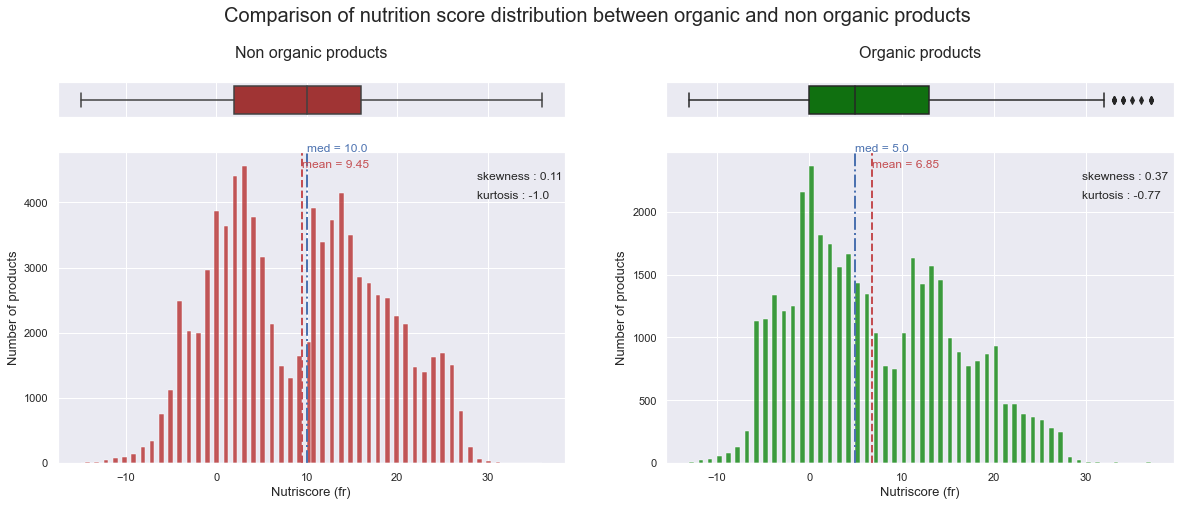

In [17]:
data_anova = data[['organic', 'nutrition-score-fr_100g']].dropna(how="any")
nutrition_score_organic = data_anova[data_anova['organic'] == True]['nutrition-score-fr_100g']
nutrition_score_non_organic = data_anova[data_anova['organic'] == False]['nutrition-score-fr_100g']

# Plotting fat distribution
fig, axes = plt.subplots(figsize=(20,7), ncols=2, nrows=2, sharex="col", gridspec_kw={"height_ratios": (.10, .90)})
fig.suptitle("Comparison of nutrition score distribution between organic and non organic products", fontsize=20, y=1.03)

plot_data_hist(nutrition_score_non_organic, 
               ax=axes[1][0], 
               box_ax=axes[0][0], 
               color="firebrick", 
               title="Non organic products", 
               xlabel="Nutriscore (fr)", 
               ylabel="Number of products")

plot_data_hist(nutrition_score_organic, 
               ax=axes[1][1], 
               box_ax=axes[0][1], 
               color="green", 
               title="Organic products", 
               xlabel="Nutriscore (fr)", 
               ylabel="Number of products")

The organic products seem to have better nutrition score than non-organic ones. **Both mean and median nutrition score are lower for organic products.**

Now we want do check is this difference is really representative, using an ANOVA test.

### 4.2 Checking ANOVA hypothesis<a name="anova_hypothesis"></a>
To perform standard ANOVA (using Fisher test) our two samples have to : 
* Be independant, **which is the case here**, a product cannot be both organic and non-organic
* Have similar variances
* Be normally distributed

#### Checking normality of distributions : Shapiro-Wilk test
The null (H0) hypothesis is that the distribution is Gaussian.

In [18]:
stat, p = sp.stats.shapiro(nutrition_score_non_organic.sample(5000))
print('Non organic products : shapiro=%.3f, p=%.3f' % (stat, p))
if p > 0.05:
    print('Non organic products nutrition score follows a Gaussian distribution')
else:
    print('Non organic products nutrition score probably NOT follows a Gaussian distribution')
    
print("\n")
    
stat, p = sp.stats.shapiro(nutrition_score_organic.sample(5000))
print('Shapiro test result = %.3f, p=%.3f' % (stat, p))
if p > 0.05:
    print('Organic products nutrition score follows a Gaussian distribution')
else:
    print('Organic products nutrition score probably NOT follows a Gaussian distribution')

Non organic products : shapiro=0.970, p=0.000
Non organic products nutrition score probably NOT follows a Gaussian distribution


Shapiro test result = 0.966, p=0.000
Organic products nutrition score probably NOT follows a Gaussian distribution


To confirm this result, we can plot the QQ-plot of our two distributions with the Gaussian distribution, in order to check if they look like a straight line, which would be representative of a Gaussian distribution.

Text(0.5, 1.0, 'Organic product')

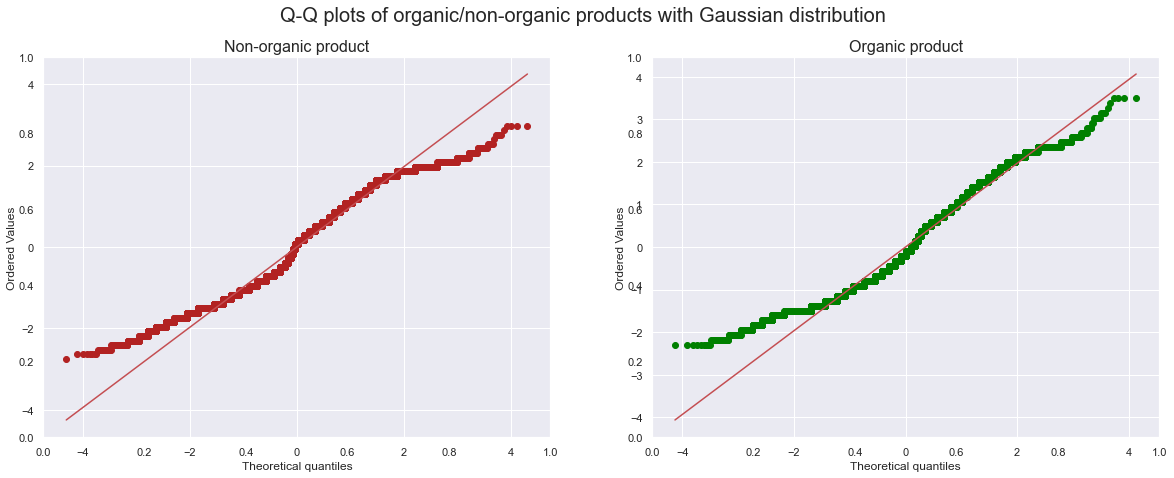

In [19]:
fig, axes = plt.subplots(figsize=(20,7), ncols=2)
fig.suptitle("Q-Q plots of organic/non-organic products with Gaussian distribution", fontsize=20)

# Centering and reducing values for qq plot
nutrition_score_non_organic_qq = (nutrition_score_non_organic - nutrition_score_non_organic.mean())/nutrition_score_non_organic.std()
nutrition_score_organic_qq = (nutrition_score_organic - nutrition_score_organic.mean())/nutrition_score_organic.std()

ax = fig.add_subplot(121)
sp.stats.probplot(nutrition_score_non_organic_qq, dist="norm", plot=plt)
ax.get_lines()[0].set_markerfacecolor('firebrick')
ax.get_lines()[0].set_markeredgecolor('firebrick')
ax.set_title("Non-organic product", fontsize=16)

ax = fig.add_subplot(122)
sp.stats.probplot(nutrition_score_organic_qq, dist="norm", plot=plt)
ax.get_lines()[0].set_markerfacecolor('green')
ax.get_lines()[0].set_markeredgecolor('green')
ax.set_title("Organic product", fontsize=16)

#### Checking variances similarity : Levene test
For the variances similarity, we could have used the Bartlett test but the Levene one is more accurate with non-gaussian distributions.

The null (H0) hypothesis is that the variances are similar.

In [20]:
print("Variance of nutriscore for non-organic products = " + str(nutrition_score_non_organic.var()))
print("Variance of nutriscore for organic products = " + str(nutrition_score_organic.var()))

print('\n')
stat, p = sp.stats.levene(nutrition_score_organic, nutrition_score_non_organic)
print('Levene test result = %.3f, p=%.3f' % (stat, p))
if p > 0.05:
    print('Samples DO validate the variances similarity hypothesis')
else:
    print('Samples do NOT validate the variances similarity hypothesis')

Variance of nutriscore for non-organic products = 79.15746935226983
Variance of nutriscore for organic products = 74.20597021788714


Levene test result = 228.119, p=0.000
Samples do NOT validate the variances similarity hypothesis


### 4.3 Performing Kruskal-Wallis ANOVA<a name="kruskal_wallis"></a>
As we checked above, we cannot perform a standard ANOVA because our sample are not normally distributed and do not have similar variances.

To check if whether or not the organic label have an impact on the nutrition score, we can still use the Kruskal-Wallis ANOVA.

In [21]:
stat, p = sp.stats.kruskal(nutrition_score_non_organic.sample(37000), nutrition_score_organic.sample(37000))
print('stat=%.3f, p=%.3f' % (stat, p))
if p > 0.05:
    print('The mean/median difference between distributions is not representative.')
else:
    print('The mean/median difference between distributions is representative.')

stat=1615.584, p=0.000
The mean/median difference between distributions is representative.


### 4.4 Conclusion<a name="anova_conclusion"></a>
Organic products do globally have a better nutrition score than non-organic ones.

## 5. Exploring our variables with a PCA<a name="pca"></a>
The goal of this part is to manage a PCA on our dataset to see if some variables could be merged ; or to define so products categories.

In the code below, we can see on the scree plot that the **4 first components are pretty important** so I decided to plot the 2 first correlation circles.

### Correlation circles

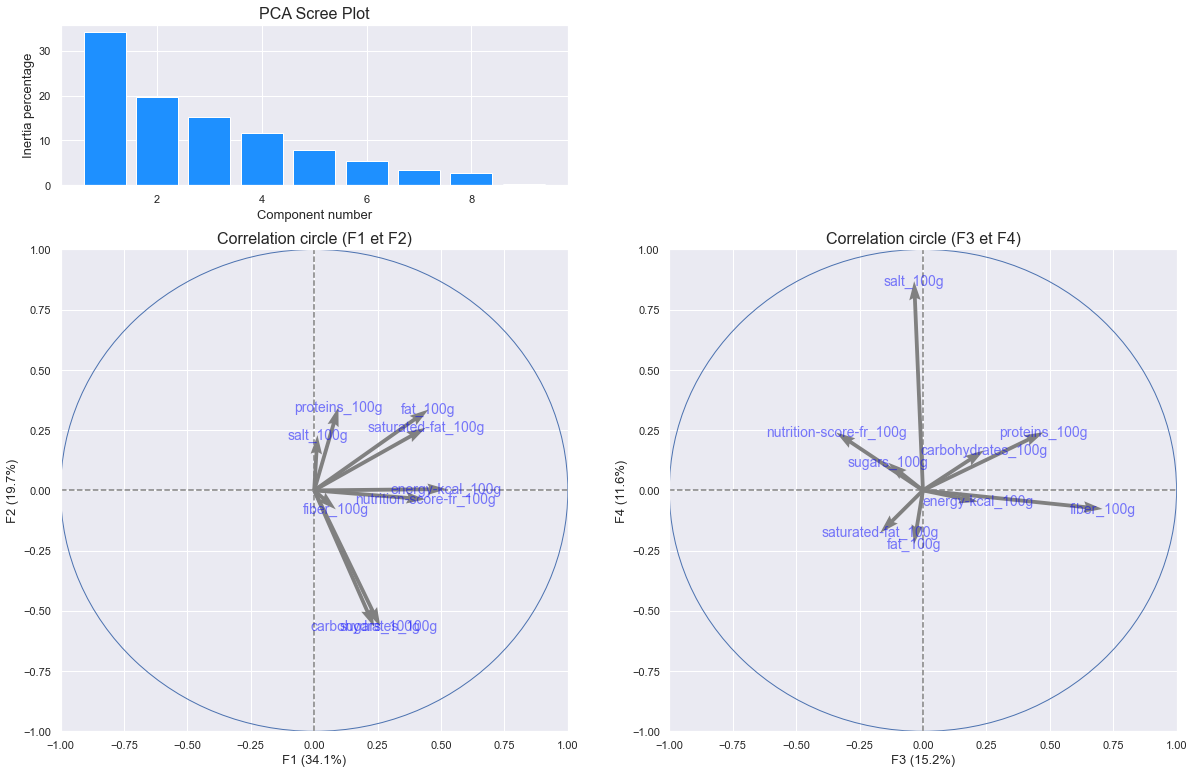

In [22]:
N_COMP=9

# Keeping only nutritional columns and droping rows with one or many NA
data_dropped = data.copy(deep=True).dropna(how="any")
data_pca = data[get_nutritional_columns(data)].dropna(how="any")

X = data_pca.values
names = data_dropped["product_name"]
features = data_pca.columns

# Centering and recucting data
std_scale = preprocessing.StandardScaler().fit(X)
X_scaled = std_scale.transform(X)

# Calculating principal components
pca = decomposition.PCA(n_components=N_COMP)
pca.fit(X_scaled)

fig, axes = plt.subplots(figsize=(20,13), ncols=2, nrows=2, gridspec_kw={"height_ratios": (.25, .75)})
display_scree_plot(pca, color="dodgerblue", ax=axes[0][0], plot_cumulative=False)
axes[0][1].axis('off')

display_pca_circles(pca, axis_ranks=(0,1), labels = np.array(features), ax=axes[1][0])
display_pca_circles(pca, axis_ranks=(2,3), labels = np.array(features), ax=axes[1][1])

On **the first circle** (F1,F2) we can see that :
 * **the most calorific products** are on the right of the circle
 * the bottom of the circle contains more **sweet products** while the upper part contains more **fat products**.
 
On **the second circle** (F3,F4) we can notice : 
 * the upper part contains the **most salted products** 
 * the right part contains the more "**fibered** and proteined" ones
 
They are nothing to do with that because in our case, we want to keep the nutrient detail so grouping columns is not very interesting for us.

### Projected data
Let's confirm our observations on the (F1,F2) by projecting somr products on it.

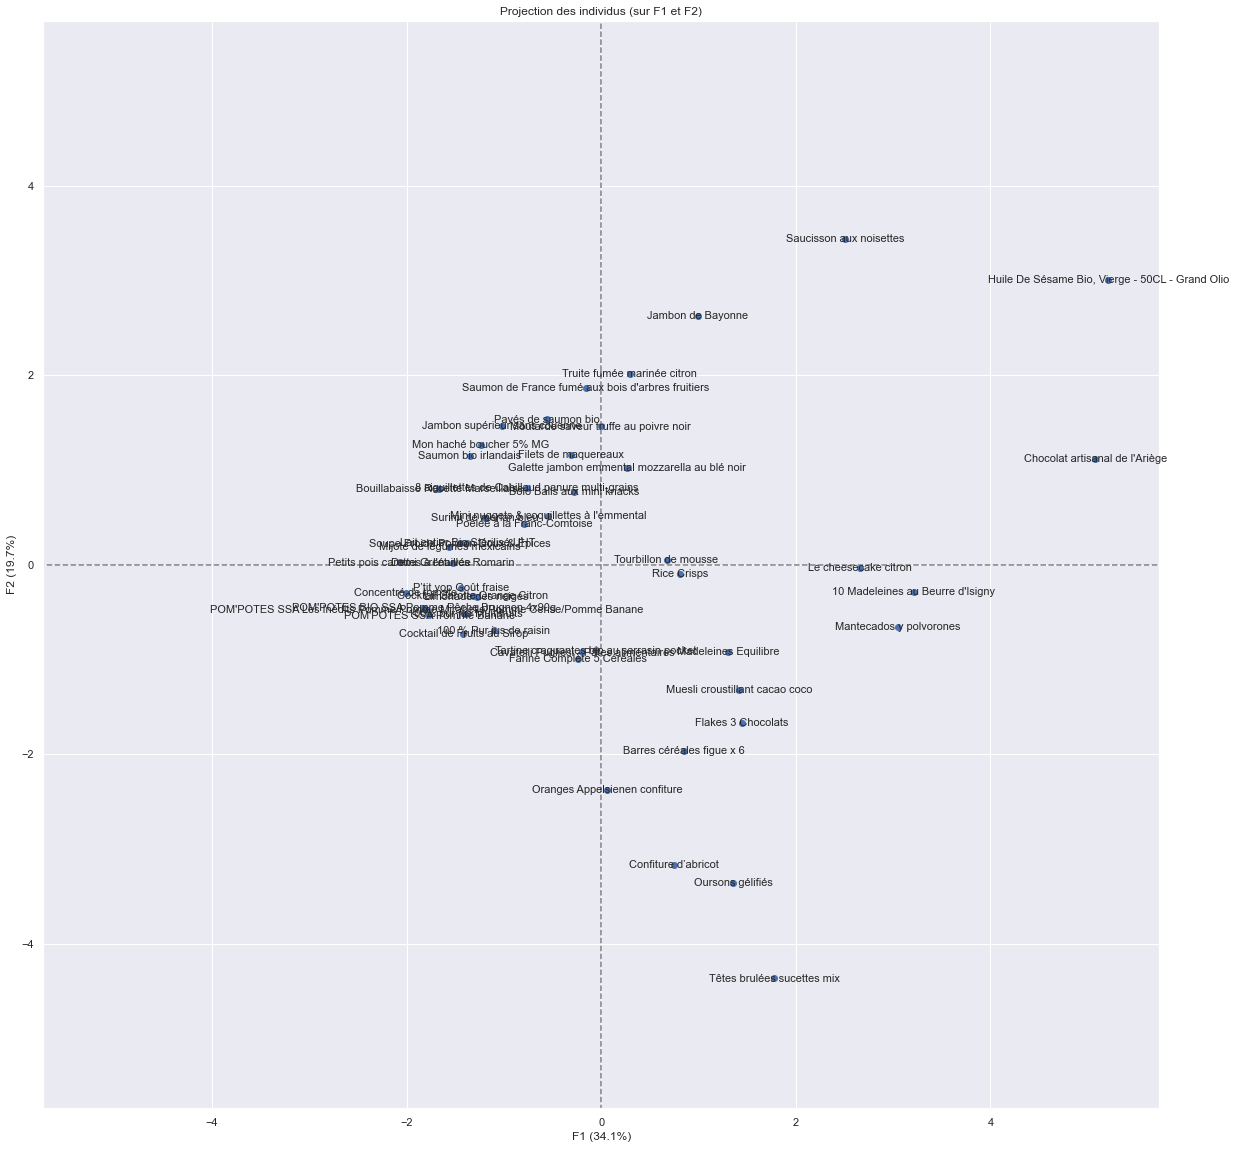

In [23]:
# Projection des individus
data_proj = data_dropped.sample(50)

X = data_proj[get_nutritional_columns(data_proj)].values
names = data_proj["product_name"]
features = data_proj.columns

# Centering and recucting data
std_scale = preprocessing.StandardScaler().fit(X)
X_scaled = std_scale.transform(X)
X_projected = pca.transform(X_scaled)

fig = plt.figure(figsize=(20,20))
display_factorial_planes(X_projected, pca, (0,1), labels = np.array(names), ax=plt.gca())

The projection confirm what we just said : 
* On top right we have very fat products like cheese, cream and some chocolates...
* On the bottom right we have very sweet products like cakes, biscuits, jams...
* On the left, products are more verticaly centered (not extremely sweet or fat) and seem to be more salted products

## 6. Training nutrigrade KNN<a name="nutrigrade_knn"></a>

### 6.1 Defining optimal K value<a name="knn_testing_k"></a>
To accelerate run times we only test the different parameters using 30% of the dataset.
The optimal values have been choosen after running these cells with 100% dataset.

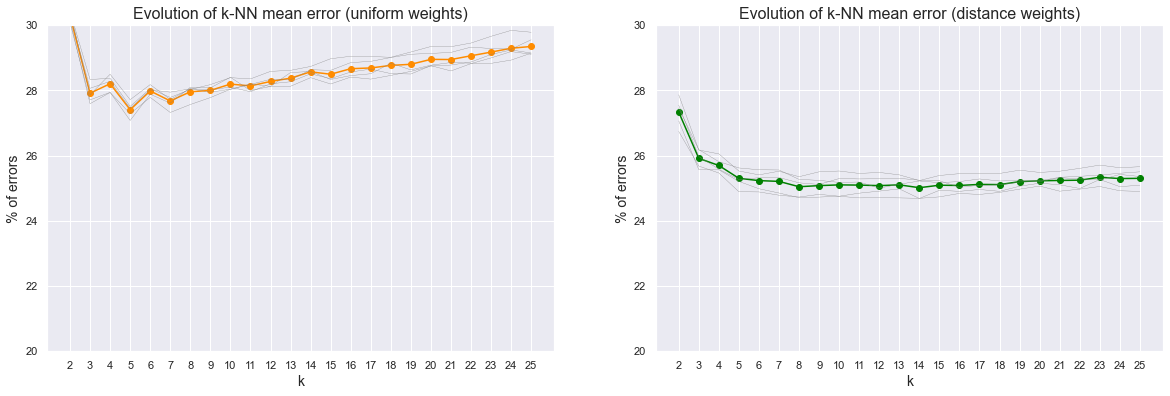

In [24]:
fig, axes = plt.subplots(figsize=(20,6), ncols=2)
SAMPLE_SIZE=30

plot_knn_errors(data, 
                sample_size=SAMPLE_SIZE, 
                k_max=25, 
                ax=axes[0], 
                color="darkorange", 
                weights="uniform",
                title="Evolution of k-NN mean error (uniform weights)")

plot_knn_errors(data, 
                sample_size=SAMPLE_SIZE, 
                k_max=25, 
                ax=axes[1], 
                color="green", 
                weights="distance",
                title="Evolution of k-NN mean error (distance weights)")

for ax in axes:
    ax.set_ylim(ymin=20, ymax=30)

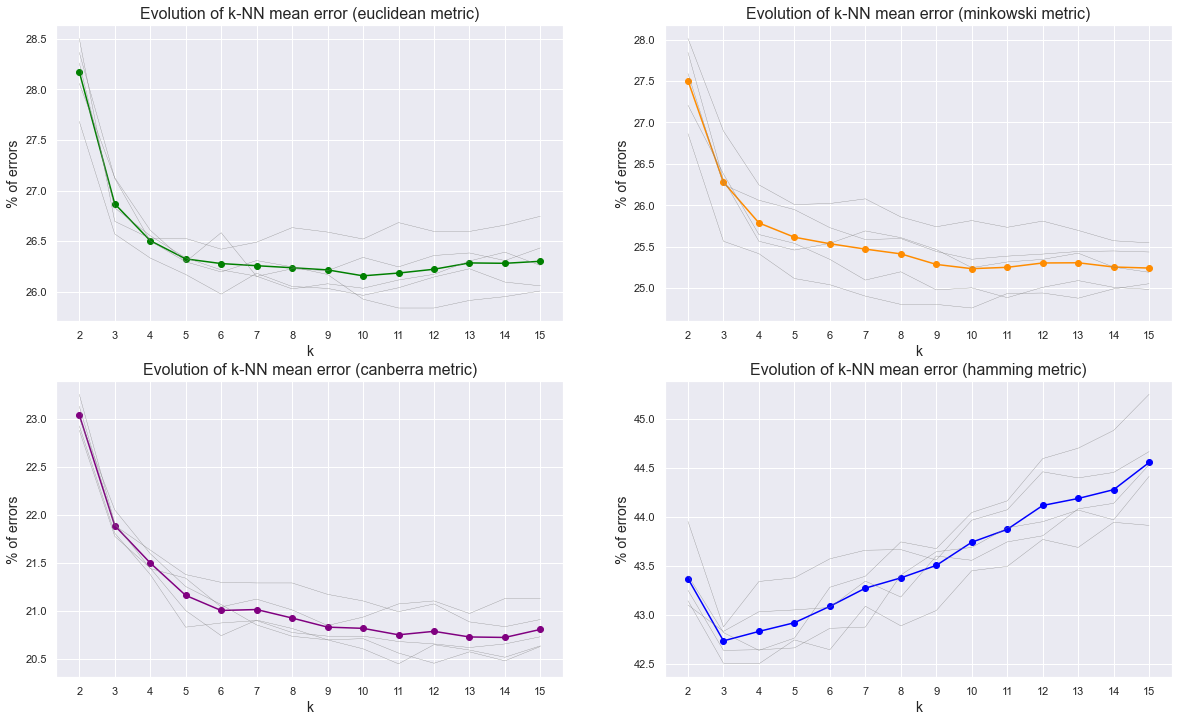

In [25]:
fig, axes = plt.subplots(figsize=(20,12), ncols=2, nrows=2)
SAMPLE_SIZE=30

plot_knn_errors(data, 
                sample_size=SAMPLE_SIZE, 
                k_max=15, 
                ax=axes[0][0], 
                color="green", 
                weights="distance",
                title="Evolution of k-NN mean error (euclidean metric)",
                metric='euclidean')

plot_knn_errors(data, 
                sample_size=SAMPLE_SIZE, 
                k_max=15, 
                ax=axes[0][1], 
                color="darkorange", 
                weights="distance",
                title="Evolution of k-NN mean error (minkowski metric)",
                metric='minkowski')

plot_knn_errors(data, 
                sample_size=SAMPLE_SIZE, 
                k_max=15, 
                ax=axes[1][0], 
                color="purple", 
                weights="distance",
                title="Evolution of k-NN mean error (canberra metric)",
                metric='canberra')

plot_knn_errors(data, 
                sample_size=SAMPLE_SIZE, 
                k_max=15, 
                ax=axes[1][1], 
                color="blue", 
                weights="distance",
                title="Evolution of k-NN mean error (hamming metric)",
                metric='hamming')



### 6.2 Training KNN <a name="knn_training"></a>
We can now train our k-NN on the full dataset with the parameters we defined above : 
* Canberra metric
* Distance weights
* k = 8

In [26]:
knn_inputs, knn_outputs = get_knn_data_sample(data, sample_size=100)
x_train, x_test, y_train, y_test = train_test_split(knn_inputs, knn_outputs, train_size=0.8)
knn = neighbors.KNeighborsClassifier(n_neighbors=8, weights='distance', metric='canberra')
knn.fit(x_train, y_train).score(x_test, y_test)

0.8178734091803648

## 7. Imputing missing values<a name="imputing_missing"></a>

In [27]:
# We define a new data variable with imputed values for our application
app_data = data.copy(deep=True)

# We remove the nutrition-score which is not useful anymore
app_data.drop(columns=['nutrition-score-fr_100g'], inplace=True)
app_data

# Removing products with no category/categories tags to improve compute times
app_data = app_data.dropna(how='all', subset=['main_category','categories_tags'])

### 7.1 Imputing other nutritional values using category mean<a name="imputing_nutritional"></a>

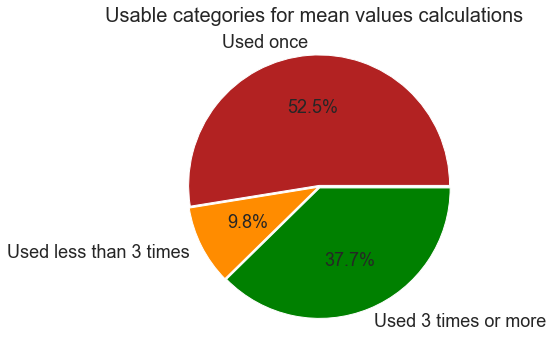

In [28]:
USE_THRESHOLD = 3
main_category_counts = app_data['main_category'].value_counts().to_frame()
pie_chart_values = {
    'Used once': len(main_category_counts[main_category_counts['main_category'] == 1])/len(main_category_counts),
    'Used less than ' + str(USE_THRESHOLD) + ' times': len(main_category_counts[(main_category_counts['main_category'] > 1) & (main_category_counts['main_category'] < USE_THRESHOLD)])/len(main_category_counts),
    'Used ' + str(USE_THRESHOLD) + ' times or more ': len(main_category_counts[main_category_counts['main_category'] >= USE_THRESHOLD])/len(main_category_counts)
}

plt.figure(figsize=(6,6))
plt.suptitle("Usable categories for mean values calculations", fontsize=20, y=0.92)
plt.pie(pie_chart_values.values(), 
        labels=pie_chart_values.keys(), 
        autopct="%.1f%%", 
        explode=[0.01]*3, 
        colors=["firebrick", "darkorange", "green"],
        textprops={'size': 18})

# Storing in a list the categories used more than X times (to calculate a mean)
valid_categories = main_category_counts[main_category_counts['main_category'] >= USE_THRESHOLD].index.to_list()

In [29]:
# Keeping only interesting data
nutritional_columns_to_fill = get_nutritional_columns(app_data, exclude_starts=['nutrition', 'energy', 'fiber'])
to_fill_data = app_data[(app_data['main_category'].isin(valid_categories)) & (app_data[nutritional_columns_to_fill].isna().any(axis=1))][nutritional_columns_to_fill + ['main_category']]

# Calculate all categories mean nutritional values
categories_means = data[data['main_category'].isin(valid_categories)][nutritional_columns_to_fill + ['main_category']].dropna(how="any")
categories_means = categories_means.groupby('main_category').mean()

# Filling the missing data with the mean for the product main category
for index, row in to_fill_data.iterrows():
    if row['main_category'] in categories_means.index.to_list():
        for column_name in nutritional_columns_to_fill:
            if pd.isna(row[column_name]):
                app_data.loc[index, column_name] = categories_means.loc[row['main_category'], column_name]

### 7.2 Imputing missing nutrigrades using KNN<a name="imputing_nutrigrade"></a>

In [30]:
# Preparing data for prediction
knn_mandatory_columns = get_nutritional_columns(data, exclude_starts=['fiber', 'nutrition'])
fillable_rows = app_data[app_data['nutriscore_grade'].isnull()].dropna(subset=knn_mandatory_columns, how="any").filter(items=knn_mandatory_columns, axis=1)

# Predicting missing nutrigrades
predicted_nutrigrades = knn.predict(fillable_rows)

In [31]:
# Merging the existing nutriscore grade with the predicted ones
def convert_numeric_to_nutrigrade(number):
    letters = ['A', 'B', 'C', 'D', 'E']
    return letters[number]

def calculate_nutrigrade_score(letter):
    if pd.isnull(letter):
        return 0
    letters = ['E', 'D', 'C', 'B', 'A']
    return (letters.index(letter) + 1)/5

fillable_rows['nutrigrade'] = predicted_nutrigrades
fillable_rows['nutrigrade'] = fillable_rows['nutrigrade'].apply(convert_numeric_to_nutrigrade)
fillable_rows = fillable_rows.filter(items=['nutrigrade'], axis=1)

app_data = app_data.merge(fillable_rows, left_index=True, right_index=True, how='left')
app_data.loc[app_data['nutriscore_grade'].isnull(), 'nutriscore_grade'] = app_data['nutrigrade']
app_data.drop(columns=['nutrigrade'], inplace=True)

# Creating a nutrigrade score (A=1 to E=O)
app_data['nutrigrade_score'] = app_data['nutriscore_grade']
app_data['nutrigrade_score'] = app_data['nutrigrade_score'].apply(calculate_nutrigrade_score)

## 8. Prototyping our application<a name="prototype"></a>

In [33]:
product = data.sample(1)
similar = find_similar_products(app_data, product, 3)

result_data = pd.concat([product, similar])
export_result_for_display(result_data)

result_data

NameError: name 'product' is not defined